In [5]:
import torch

import sys
sys.path.append("/home/jdli/xiasangju/kurucz1/")  # Adjust the path to include the parent directory
from kuruczone import emulator

# Load pre-trained model
model = emulator.load_from_checkpoint("/home/jdli/xiasangju/kurucz1/checkpoints_0409/best_model.pt",
                                    dataset_path="/home/jdli/xiasangju/kurucz1/data/kurucz_v4.pt")

# Create stellar parameter inputs
stellar_params = torch.tensor([[5000.0, 4.5, -0.5, 0.0]])  # Teff, log(g), [Fe/H], [α/Fe]

# Create optical depth grid
tau_grid = torch.logspace(-6, 2, 80).unsqueeze(0)  # Shape: [1, 100]

# Predict atmospheric structure
atmosphere = model.predict(stellar_params, tau_grid)

# Access variables
temperature = atmosphere['T']  # Shape: [batch_size, n_depth_points]
pressure = atmosphere['P']

Model loaded: trained for 55 epochs, final loss: 0.000762


In [6]:
atmosphere.keys()  # Check available keys in the atmosphere dictionary

dict_keys(['RHOX', 'T', 'P', 'XNE', 'ABROSS', 'ACCRAD', 'TAU'])

# Teff

In [13]:
import numpy as np
# ====> DEFINE YOUR CUSTOM Teff GRID HERE <====
# Provide a Python list or NumPy array of the specific Teff values (in Kelvin)
# you want to simulate.
teff_grid_custom = np.linspace(3000, 10000, 1000) # Example: 5 values from 3000K to 9000K
# Examples:
# teff_grid_custom = [3000.0, 6000.0, 9000.0] # A simple list
# teff_grid_custom = np.array([4000, 4500, 5000, 5500, 6000], dtype=np.float32) # Using numpy

# Define the *fixed* other stellar parameters - these will be used for ALL Teff values
logg_val = 4.5
feh_val = -0.5
alpha_fe_val = 0.0

# Define optical depth grid parameters (should match the original code/model training)
num_depth_points = 80
tau_min_log = -6
tau_max_log = 2
# --- End Configuration ---
# --- Prepare Inputs ---

# 1. Create the Teff tensor directly from your custom grid
teff_values = torch.tensor(teff_grid_custom, dtype=torch.float32)

# 2. Create the batch of stellar parameters based on the custom Teff grid
batch_size = len(teff_values) # The batch size is now the number of Teff values you provided

# Create tensors for the constant parameters, matching the size of the Teff tensor
logg_tensor = torch.full((batch_size,), logg_val, dtype=torch.float32)
feh_tensor = torch.full((batch_size,), feh_val, dtype=torch.float32)
alpha_fe_tensor = torch.full((batch_size,), alpha_fe_val, dtype=torch.float32)

# Stack the parameter tensors column-wise to create the final batch
# Resulting shape: [batch_size, 4] corresponding to [Teff, log(g), [Fe/H], [α/Fe]] for each custom Teff
stellar_params_batch = torch.stack(
    [teff_values, logg_tensor, feh_tensor, alpha_fe_tensor],
    dim=1 # Stack along the second dimension
)
print(f"Created stellar parameter batch with shape: {stellar_params_batch.shape}")

# 3. Create optical depth grid
# Shape: [1, num_depth_points]. Assuming the model broadcasts this across the batch.
tau_grid = torch.logspace(tau_min_log, tau_max_log, num_depth_points).unsqueeze(0)
print(f"Using tau_grid with shape: {tau_grid.shape}")


# --- Predict Atmospheric Structures for the Batch ---
print("\nPredicting atmospheric structures for the custom Teff grid...")


with torch.no_grad():
    atmosphere_batch = model.predict(stellar_params_batch, tau_grid)
print("Prediction complete.")

# --- Access and Use Results ---
# The results are dictionaries containing tensors for the whole batch.
# T and P will have shape: [batch_size, num_depth_points]
rho_batch = atmosphere_batch['RHOX']  # Density
temperatures_batch = atmosphere_batch['T']
pressures_batch = atmosphere_batch['P']
xne_batch = atmosphere_batch['XNE']
kappa_batch = atmosphere_batch['ABROSS']

Created stellar parameter batch with shape: torch.Size([1000, 4])
Using tau_grid with shape: torch.Size([1, 80])

Predicting atmospheric structures for the custom Teff grid...
Prediction complete.



Generating plots...


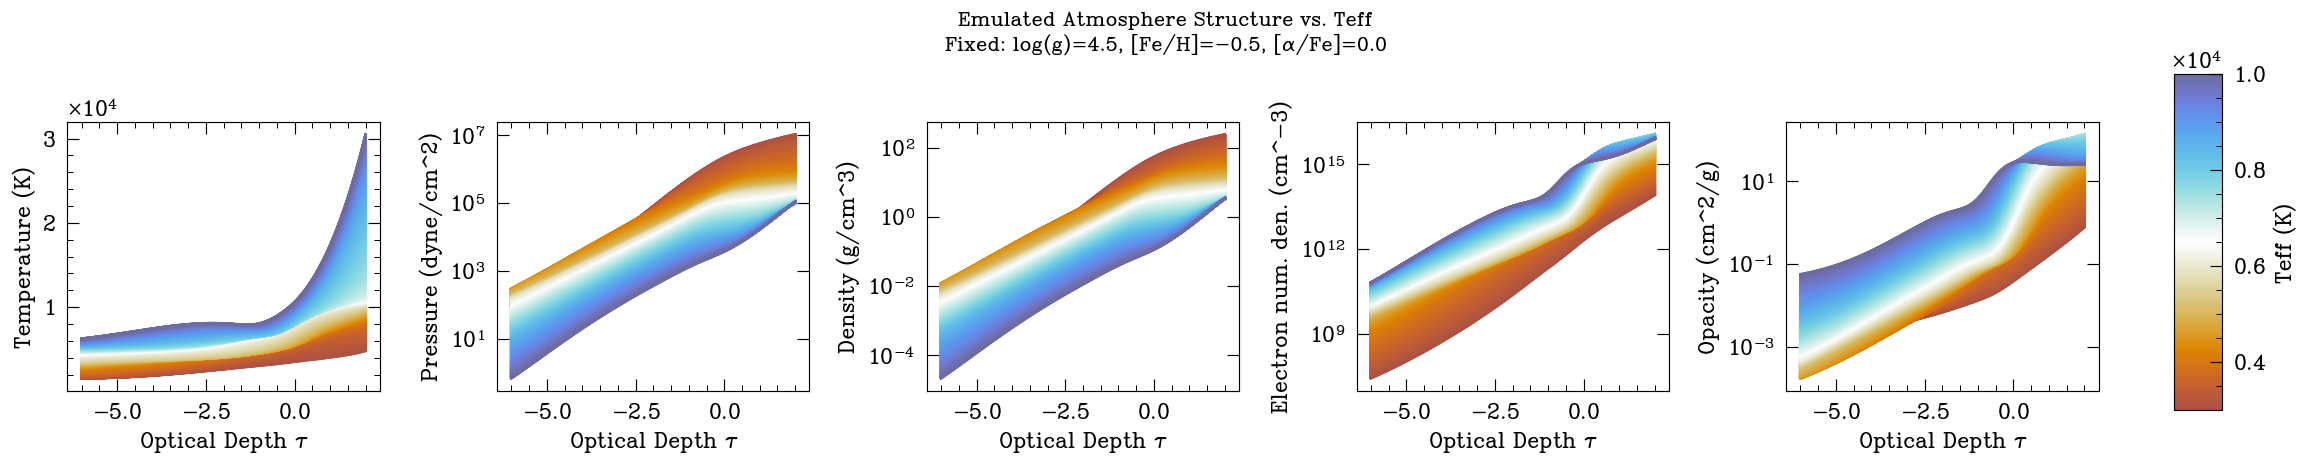

In [32]:
import torch
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import cmasher as cmr
import smplotlib


teff_values_np = teff_values.numpy()  # Convert to NumPy for plotting
# --- Plotting Section ---
print("\nGenerating plots...")

# Define the variables to plot, their labels, and if Y-axis should be log scale
variables_to_plot = {
    'Temperature': {'data': temperatures_batch, 'label': 'Temperature (K)', 'logy': False},
    'Pressure': {'data': pressures_batch, 'label':  'Pressure (dyne/cm^2)', 'logy': True},
    'Density': {'data': rho_batch, 'label': 'Density (g/cm^3)', 'logy': True},
    'Electron Density': {'data': xne_batch, 'label': 'Electron num. den. (cm^-3)', 'logy': True}, # XNE might need log scale
    'Opacity': {'data': kappa_batch, 'label': 'Opacity (cm^2/g)', 'logy': True}
}
plot_keys = list(variables_to_plot.keys())

# Calculate log10(tau) for the x-axis
log_tau_values_np = np.log10(tau_grid.numpy()).flatten()  # Flatten to 1D for plotting

# Set up colormap and normalization for Teff
cmap = plt.get_cmap('cmr.prinsenvlag')  # Using 'plasma' colormap
norm = colors.Normalize(vmin=teff_values.min(), vmax=teff_values.max())

# Create figure and axes (5 rows, 1 column)
fig, axes = plt.subplots(1, len(plot_keys), figsize=(20, 4))

# Loop through each variable and plot it on its corresponding subplot
for i, key in enumerate(plot_keys):
    ax = axes[i]
    var_info = variables_to_plot[key]
    data_batch = var_info['data']
    ylabel = var_info['label']
    use_log_y = var_info['logy']

    # Plot data for each Teff
    for teff_idx in range(batch_size):
        color = cmap(norm(teff_values_np[teff_idx]))
        ax.plot(log_tau_values_np, data_batch[teff_idx, :], color=color, alpha=0.85, linewidth=1.5)

    # Configure subplot
    ax.set_ylabel(ylabel)
    if use_log_y:
        ax.set_yscale('log')


    ax.set_xlabel(r'Optical Depth $\tau$')

    # ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    # ax.set_title(key) # Title on each subplot can be redundant with y-label

# Set x-axis label only on the bottom plot
# axes[-1].set_xlabel('log10(Optical Depth, tau)')

# Add a colorbar to the figure
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) # Needed for standalone colorbar

# Create a new axis for the colorbar and position it to the right
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Teff (K)')

# Add overall figure title
fig.suptitle(f'Emulated Atmosphere Structure vs. Teff\nFixed: log(g)={logg_val}, [Fe/H]={feh_val}, [α/Fe]={alpha_fe_val}', fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for colorbar
plt.show()

# log g

In [33]:
# ====> DEFINE YOUR CUSTOM Teff GRID HERE <====
# Provide a Python list or NumPy array of the specific Teff values (in Kelvin)
# you want to simulate.

# Define the *fixed* other stellar parameters - these will be used for ALL Teff values
teff_val = 4500
logg_val = np.linspace(1.0, 5.0, 100)  # Example: 100 values from 4.0 to 5.0
feh_val = -0.5
alpha_fe_val = 0.0

# Define optical depth grid parameters (should match the original code/model training)
num_depth_points = 80
tau_min_log = -6
tau_max_log = 2
# --- End Configuration ---
# --- Prepare Inputs ---

# 1. Create the Teff tensor directly from your custom grid
logg_values = torch.tensor(logg_val, dtype=torch.float32)
# 2. Create the batch of stellar parameters based on the custom Teff grid
batch_size = len(logg_values) # The batch size is now the number of Teff values you provided

# Create tensors for the constant parameters, matching the size of the Teff tensor
teff_tensor = torch.full((batch_size,), teff_val, dtype=torch.float32)
feh_tensor = torch.full((batch_size,), feh_val, dtype=torch.float32)
alpha_fe_tensor = torch.full((batch_size,), alpha_fe_val, dtype=torch.float32)

# Stack the parameter tensors column-wise to create the final batch
# Resulting shape: [batch_size, 4] corresponding to [Teff, log(g), [Fe/H], [α/Fe]] for each custom Teff
stellar_params_batch = torch.stack(
    [teff_tensor, logg_values, feh_tensor, alpha_fe_tensor],
    dim=1 # Stack along the second dimension
)
print(f"Created stellar parameter batch with shape: {stellar_params_batch.shape}")

# 3. Create optical depth grid
# Shape: [1, num_depth_points]. Assuming the model broadcasts this across the batch.
tau_grid = torch.logspace(tau_min_log, tau_max_log, num_depth_points).unsqueeze(0)
print(f"Using tau_grid with shape: {tau_grid.shape}")

with torch.no_grad():
    atmosphere_batch = model.predict(stellar_params_batch, tau_grid)
print("Prediction complete.")

# --- Access and Use Results ---
# The results are dictionaries containing tensors for the whole batch.
# T and P will have shape: [batch_size, num_depth_points]
rho_batch = atmosphere_batch['RHOX']  # Density
temperatures_batch = atmosphere_batch['T']
pressures_batch = atmosphere_batch['P']
xne_batch = atmosphere_batch['XNE']
kappa_batch = atmosphere_batch['ABROSS']

Created stellar parameter batch with shape: torch.Size([100, 4])
Using tau_grid with shape: torch.Size([1, 80])
Prediction complete.



Generating plots...


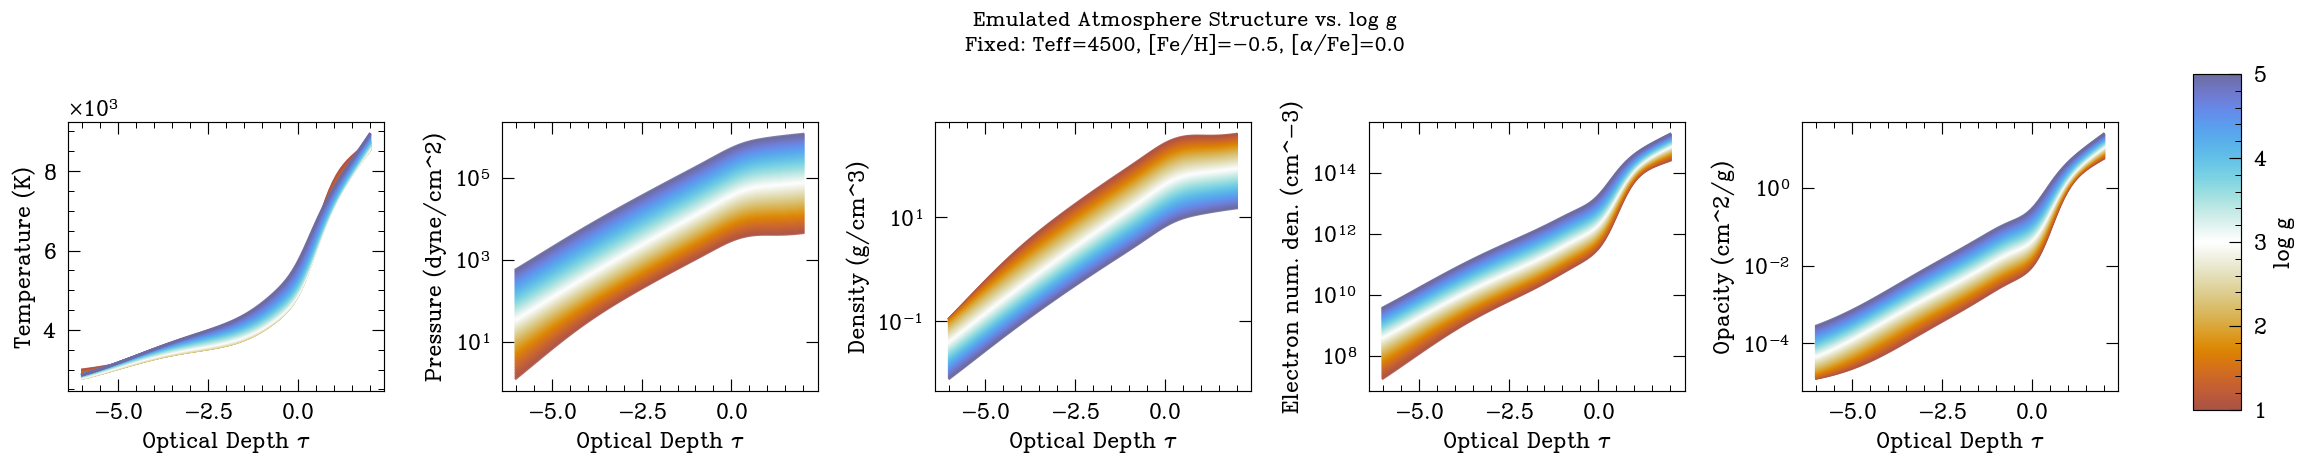

In [36]:
import torch
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import cmasher as cmr
import smplotlib


teff_values_np = teff_values.numpy()  # Convert to NumPy for plotting
# --- Plotting Section ---
print("\nGenerating plots...")

# Define the variables to plot, their labels, and if Y-axis should be log scale
variables_to_plot = {
    'Temperature': {'data': temperatures_batch, 'label': 'Temperature (K)', 'logy': False},
    'Pressure': {'data': pressures_batch, 'label':  'Pressure (dyne/cm^2)', 'logy': True},
    'Density': {'data': rho_batch, 'label': 'Density (g/cm^3)', 'logy': True},
    'Electron Density': {'data': xne_batch, 'label': 'Electron num. den. (cm^-3)', 'logy': True}, # XNE might need log scale
    'Opacity': {'data': kappa_batch, 'label': 'Opacity (cm^2/g)', 'logy': True}
}
plot_keys = list(variables_to_plot.keys())

# Calculate log10(tau) for the x-axis
log_tau_values_np = np.log10(tau_grid.numpy()).flatten()  # Flatten to 1D for plotting

# Set up colormap and normalization for Teff
cmap = plt.get_cmap('cmr.prinsenvlag')  # Using 'plasma' colormap
norm = colors.Normalize(vmin=logg_values.min(), vmax=logg_values.max())

# Create figure and axes (5 rows, 1 column)
fig, axes = plt.subplots(1, len(plot_keys), figsize=(20, 4))

# Loop through each variable and plot it on its corresponding subplot
for i, key in enumerate(plot_keys):
    ax = axes[i]
    var_info = variables_to_plot[key]
    data_batch = var_info['data']
    ylabel = var_info['label']
    use_log_y = var_info['logy']

    # Plot data for each Teff
    for idx in range(batch_size):
        color = cmap(norm(logg_values[idx]))
        ax.plot(log_tau_values_np, data_batch[idx, :], color=color, alpha=0.85, linewidth=1.5)

    # Configure subplot
    ax.set_ylabel(ylabel)
    if use_log_y:
        ax.set_yscale('log')

    ax.set_xlabel(r'Optical Depth $\tau$')

# Add a colorbar to the figure
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) # Needed for standalone colorbar

# Create a new axis for the colorbar and position it to the right
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('log g')

# Add overall figure title
fig.suptitle(f'Emulated Atmosphere Structure vs. log g\nFixed: Teff={teff_val}, [Fe/H]={feh_val}, [α/Fe]={alpha_fe_val}', fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for colorbar
plt.show()

# feh

In [37]:
# ====> DEFINE YOUR CUSTOM Teff GRID HERE <====
# Provide a Python list or NumPy array of the specific Teff values (in Kelvin)
# you want to simulate.

# Define the *fixed* other stellar parameters - these will be used for ALL Teff values
teff_val = 4500
# logg_val = np.linspace(1.0, 5.0, 100)  # Example: 100 values from 4.0 to 5.0
logg_val = 4.5
feh_val = np.linspace(-2.0, 0.5, 100)  # Example: 100 values from -2.0 to 0.5
alpha_fe_val = 0.0

# Define optical depth grid parameters (should match the original code/model training)
num_depth_points = 80
tau_min_log = -6
tau_max_log = 2
# --- End Configuration ---
# --- Prepare Inputs ---

# 1. Create the Teff tensor directly from your custom grid
feh_values = torch.tensor(feh_val, dtype=torch.float32)
# 2. Create the batch of stellar parameters based on the custom Teff grid
batch_size = len(feh_values) # The batch size is now the number of Teff values you provided

# Create tensors for the constant parameters, matching the size of the Teff tensor
teff_tensor = torch.full((batch_size,), teff_val, dtype=torch.float32)
logg_tensor = torch.full((batch_size,), logg_val, dtype=torch.float32)
alpha_fe_tensor = torch.full((batch_size,), alpha_fe_val, dtype=torch.float32)

# Stack the parameter tensors column-wise to create the final batch
# Resulting shape: [batch_size, 4] corresponding to [Teff, log(g), [Fe/H], [α/Fe]] for each custom Teff
stellar_params_batch = torch.stack(
    [teff_tensor, logg_tensor, feh_values, alpha_fe_tensor],
    dim=1 # Stack along the second dimension
)
print(f"Created stellar parameter batch with shape: {stellar_params_batch.shape}")

# 3. Create optical depth grid
# Shape: [1, num_depth_points]. Assuming the model broadcasts this across the batch.
tau_grid = torch.logspace(tau_min_log, tau_max_log, num_depth_points).unsqueeze(0)
print(f"Using tau_grid with shape: {tau_grid.shape}")

with torch.no_grad():
    atmosphere_batch = model.predict(stellar_params_batch, tau_grid)
print("Prediction complete.")

# --- Access and Use Results ---
# The results are dictionaries containing tensors for the whole batch.
# T and P will have shape: [batch_size, num_depth_points]
rho_batch = atmosphere_batch['RHOX']  # Density
temperatures_batch = atmosphere_batch['T']
pressures_batch = atmosphere_batch['P']
xne_batch = atmosphere_batch['XNE']
kappa_batch = atmosphere_batch['ABROSS']

Created stellar parameter batch with shape: torch.Size([100, 4])
Using tau_grid with shape: torch.Size([1, 80])
Prediction complete.


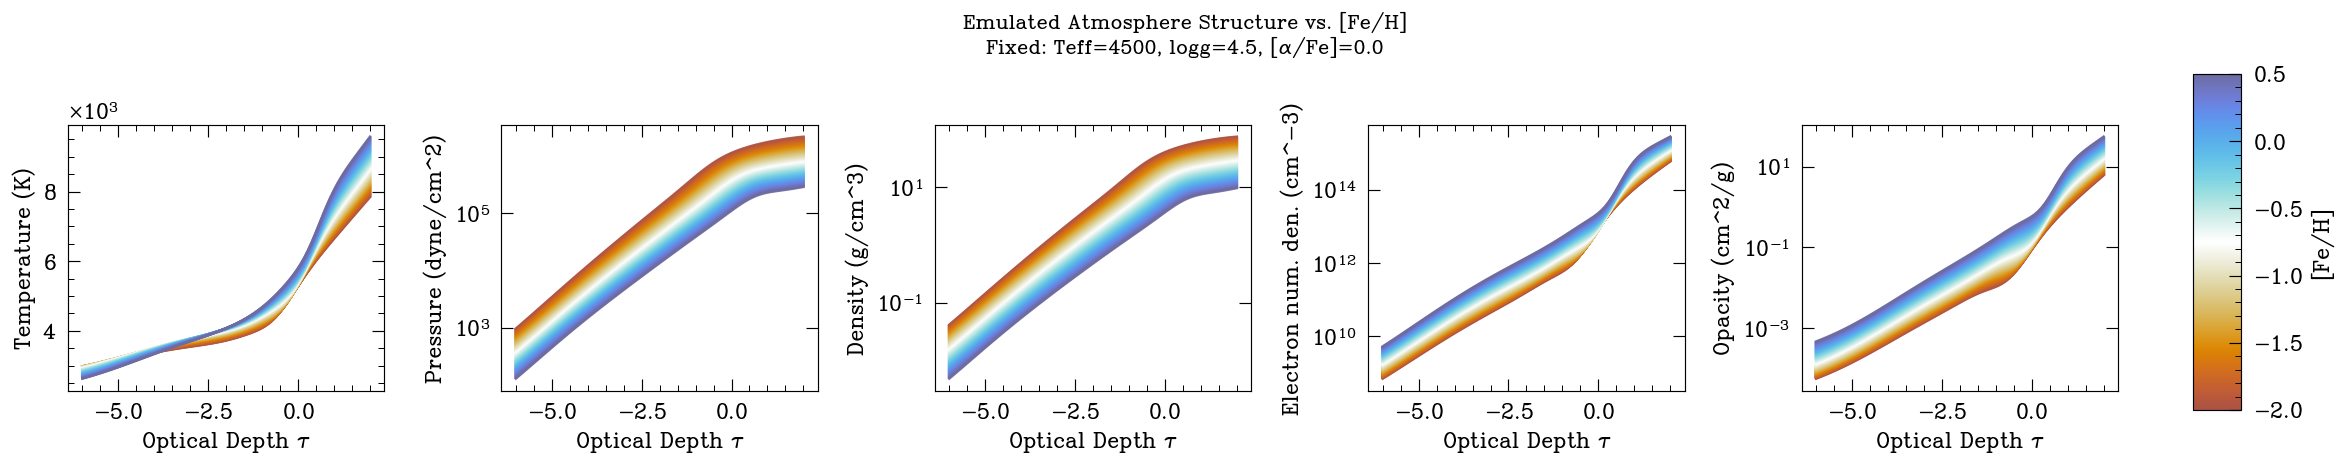

In [39]:

# Define the variables to plot, their labels, and if Y-axis should be log scale
variables_to_plot = {
    'Temperature': {'data': temperatures_batch, 'label': 'Temperature (K)', 'logy': False},
    'Pressure': {'data': pressures_batch, 'label':  'Pressure (dyne/cm^2)', 'logy': True},
    'Density': {'data': rho_batch, 'label': 'Density (g/cm^3)', 'logy': True},
    'Electron Density': {'data': xne_batch, 'label': 'Electron num. den. (cm^-3)', 'logy': True}, # XNE might need log scale
    'Opacity': {'data': kappa_batch, 'label': 'Opacity (cm^2/g)', 'logy': True}
}
plot_keys = list(variables_to_plot.keys())

# Calculate log10(tau) for the x-axis
log_tau_values_np = np.log10(tau_grid.numpy()).flatten()  # Flatten to 1D for plotting

# Set up colormap and normalization for Teff
cmap = plt.get_cmap('cmr.prinsenvlag')  # Using 'plasma' colormap
norm = colors.Normalize(vmin=feh_values.min(), vmax=feh_values.max())

# Create figure and axes (5 rows, 1 column)
fig, axes = plt.subplots(1, len(plot_keys), figsize=(20, 4))

# Loop through each variable and plot it on its corresponding subplot
for i, key in enumerate(plot_keys):
    ax = axes[i]
    var_info = variables_to_plot[key]
    data_batch = var_info['data']
    ylabel = var_info['label']
    use_log_y = var_info['logy']

    # Plot data for each Teff
    for idx in range(batch_size):
        color = cmap(norm(feh_values[idx]))
        ax.plot(log_tau_values_np, data_batch[idx, :], color=color, alpha=0.85, linewidth=1.5)

    # Configure subplot
    ax.set_ylabel(ylabel)
    if use_log_y:
        ax.set_yscale('log')

    ax.set_xlabel(r'Optical Depth $\tau$')

# Add a colorbar to the figure
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) # Needed for standalone colorbar

# Create a new axis for the colorbar and position it to the right
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('[Fe/H]')

# Add overall figure title
fig.suptitle(f'Emulated Atmosphere Structure vs. [Fe/H]\nFixed: Teff={teff_val}, logg={logg_val}, [α/Fe]={alpha_fe_val}', fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for colorbar
plt.show()

# [a/Fe]

In [40]:
# ====> DEFINE YOUR CUSTOM Teff GRID HERE <====
# Provide a Python list or NumPy array of the specific Teff values (in Kelvin)
# you want to simulate.

# Define the *fixed* other stellar parameters - these will be used for ALL Teff values
teff_val = 4500
# logg_val = np.linspace(1.0, 5.0, 100)  # Example: 100 values from 4.0 to 5.0
logg_val = 4.5
feh_val = -0.5
afe_val = np.linspace(-0.5, 0.5, 100)  # Example: 100 values from -0.5 to 0.5

# Define optical depth grid parameters (should match the original code/model training)
num_depth_points = 80
tau_min_log = -6
tau_max_log = 2
# --- End Configuration ---
# --- Prepare Inputs ---

# 1. Create the Teff tensor directly from your custom grid
afe_values = torch.tensor(afe_val, dtype=torch.float32)
# 2. Create the batch of stellar parameters based on the custom Teff grid
batch_size = len(afe_values) # The batch size is now the number of Teff values you provided

# Create tensors for the constant parameters, matching the size of the Teff tensor
teff_tensor = torch.full((batch_size,), teff_val, dtype=torch.float32)
logg_tensor = torch.full((batch_size,), logg_val, dtype=torch.float32)
feh_values = torch.full((batch_size,), feh_val, dtype=torch.float32)

# Stack the parameter tensors column-wise to create the final batch
# Resulting shape: [batch_size, 4] corresponding to [Teff, log(g), [Fe/H], [α/Fe]] for each custom Teff
stellar_params_batch = torch.stack(
    [teff_tensor, logg_tensor, feh_values, afe_values],
    dim=1 # Stack along the second dimension
)
print(f"Created stellar parameter batch with shape: {stellar_params_batch.shape}")

# 3. Create optical depth grid
# Shape: [1, num_depth_points]. Assuming the model broadcasts this across the batch.
tau_grid = torch.logspace(tau_min_log, tau_max_log, num_depth_points).unsqueeze(0)
print(f"Using tau_grid with shape: {tau_grid.shape}")

with torch.no_grad():
    atmosphere_batch = model.predict(stellar_params_batch, tau_grid)
print("Prediction complete.")

# --- Access and Use Results ---
# The results are dictionaries containing tensors for the whole batch.
# T and P will have shape: [batch_size, num_depth_points]
rho_batch = atmosphere_batch['RHOX']  # Density
temperatures_batch = atmosphere_batch['T']
pressures_batch = atmosphere_batch['P']
xne_batch = atmosphere_batch['XNE']
kappa_batch = atmosphere_batch['ABROSS']

Created stellar parameter batch with shape: torch.Size([100, 4])
Using tau_grid with shape: torch.Size([1, 80])
Prediction complete.


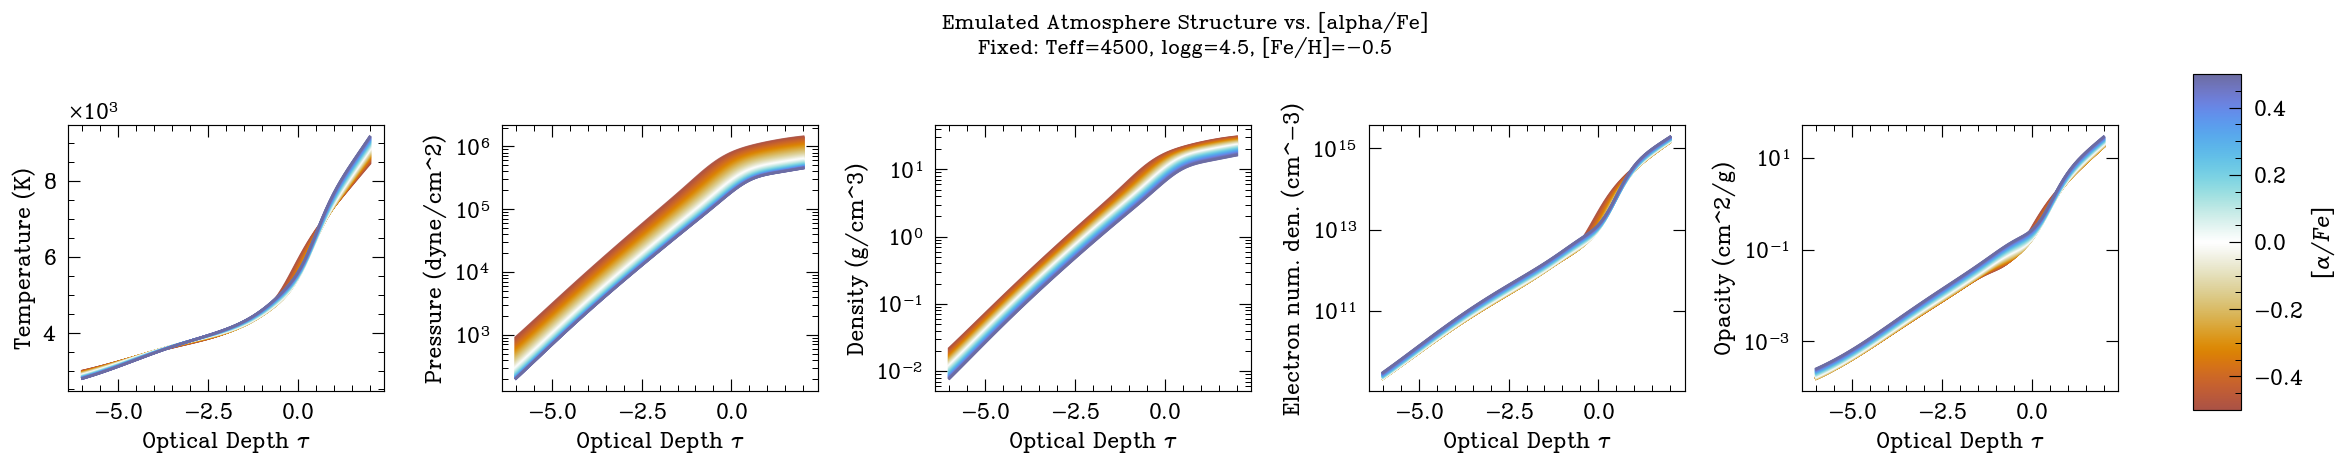

In [43]:
# Define the variables to plot, their labels, and if Y-axis should be log scale
variables_to_plot = {
    'Temperature': {'data': temperatures_batch, 'label': 'Temperature (K)', 'logy': False},
    'Pressure': {'data': pressures_batch, 'label':  'Pressure (dyne/cm^2)', 'logy': True},
    'Density': {'data': rho_batch, 'label': 'Density (g/cm^3)', 'logy': True},
    'Electron Density': {'data': xne_batch, 'label': 'Electron num. den. (cm^-3)', 'logy': True}, # XNE might need log scale
    'Opacity': {'data': kappa_batch, 'label': 'Opacity (cm^2/g)', 'logy': True}
}
plot_keys = list(variables_to_plot.keys())

# Calculate log10(tau) for the x-axis
log_tau_values_np = np.log10(tau_grid.numpy()).flatten()  # Flatten to 1D for plotting

# Set up colormap and normalization for Teff
cmap = plt.get_cmap('cmr.prinsenvlag')  # Using 'plasma' colormap
norm = colors.Normalize(vmin=afe_values.min(), vmax=afe_values.max())

# Create figure and axes (5 rows, 1 column)
fig, axes = plt.subplots(1, len(plot_keys), figsize=(20, 4))

# Loop through each variable and plot it on its corresponding subplot
for i, key in enumerate(plot_keys):
    ax = axes[i]
    var_info = variables_to_plot[key]
    data_batch = var_info['data']
    ylabel = var_info['label']
    use_log_y = var_info['logy']

    # Plot data for each Teff
    for idx in range(batch_size):
        color = cmap(norm(afe_values[idx]))
        ax.plot(log_tau_values_np, data_batch[idx, :], color=color, alpha=0.85, linewidth=1.5)

    # Configure subplot
    ax.set_ylabel(ylabel)
    if use_log_y:
        ax.set_yscale('log')

    ax.set_xlabel(r'Optical Depth $\tau$')

# Add a colorbar to the figure
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) # Needed for standalone colorbar

# Create a new axis for the colorbar and position it to the right
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(r'[$\alpha/Fe$]')

# Add overall figure title
fig.suptitle(f'Emulated Atmosphere Structure vs. [alpha/Fe]\nFixed: Teff={teff_val}, logg={logg_val}, [Fe/H]={feh_val}', fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for colorbar
plt.show()